# Propensity Model

In [1]:
import sagemaker
import boto3
import pandas as pd
from sagemaker import get_execution_role
 
region = boto3.Session().region_name
 
session = sagemaker.Session()
bucket = session.default_bucket()
print(bucket)
prefix = 'sagemaker/propensity'
 
role = get_execution_role()
 
sm = boto3.Session().client(service_name='sagemaker',region_name=region)

sagemaker-us-east-1-511905058751


### Data Processing and SageMaker Model Deployment

In [2]:
import pandas as pd
data = pd.read_csv("training_sample.csv")

In [4]:
data.columns

Index(['UserID', 'basket_icon_click', 'basket_add_list', 'basket_add_detail',
       'sort_by', 'image_picker', 'account_page_click', 'promo_banner_click',
       'detail_wishlist_add', 'list_size_dropdown', 'closed_minibasket_click',
       'checked_delivery_detail', 'checked_returns_detail', 'sign_in',
       'saw_checkout', 'saw_sizecharts', 'saw_delivery', 'saw_account_upgrade',
       'saw_homepage', 'device_mobile', 'device_computer', 'device_tablet',
       'returning_user', 'loc_uk', 'ordered'],
      dtype='object')

In [3]:
train_data = data.sample(frac=0.8,random_state=200)
test_data = data.drop(train_data.index)
test_data = test_data.drop(columns=['ordered'])

In [6]:
train_file = 'training_sample.csv';
train_data.to_csv(train_file, index=False, header=True)
train_data_s3_path = session.upload_data(path=train_file, key_prefix=prefix + "/train")
print('Train dataset uploaded to: ' + train_data_s3_path)
 
test_file = 'testing_sample.csv';
test_data.to_csv(test_file, index=False, header=False)
test_data_s3_path = session.upload_data(path=test_file, key_prefix=prefix + "/test")
print('Test dataset uploaded to: ' + test_data_s3_path)

Train dataset uploaded to: s3://sagemaker-us-east-1-511905058751/sagemaker/propensity/train/training_sample.csv
Test dataset uploaded to: s3://sagemaker-us-east-1-511905058751/sagemaker/propensity/test/testing_sample.csv


In [7]:
test_data_s3_path

's3://sagemaker-us-east-1-511905058751/sagemaker/propensity/test/testing_sample.csv'

In [4]:
import sagemaker
import boto3
from sagemaker import get_execution_role

In [9]:
region = boto3.Session().region_name
sm_rt = boto3.Session().client('runtime.sagemaker', region_name=region)

In [10]:
l="1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1"
ep_name="Propensity-Deployment"
response = sm_rt.invoke_endpoint(EndpointName=ep_name, ContentType='text/csv', Accept='text/csv', Body=l)
response = response['Body'].read().decode("utf-8")
print (response)

1



### Extracting Correlations

In [11]:
import seaborn as sns

In [8]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np
#Load boston housing dataset as an example
td = train_data.drop(columns=['UserID'])
X = td.drop(columns=['ordered'])
Y = td['ordered']
names = data.columns
rf = RandomForestRegressor()
rf.fit(X, Y)
print ("Features sorted by their score:")
print (sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.7119, 'closed_minibasket_click'), (0.2337, 'sign_in'), (0.0049, 'device_tablet'), (0.0047, 'basket_icon_click'), (0.0043, 'saw_account_upgrade'), (0.0042, 'detail_wishlist_add'), (0.0041, 'UserID'), (0.0039, 'basket_add_list'), (0.003, 'saw_sizecharts'), (0.0026, 'saw_homepage'), (0.0026, 'account_page_click'), (0.0024, 'list_size_dropdown'), (0.0023, 'returning_user'), (0.0022, 'device_mobile'), (0.0022, 'checked_delivery_detail'), (0.0021, 'basket_add_detail'), (0.002, 'sort_by'), (0.002, 'device_computer'), (0.0015, 'promo_banner_click'), (0.0014, 'image_picker'), (0.0013, 'saw_delivery'), (0.0005, 'checked_returns_detail'), (0.0001, 'saw_checkout')]


In [12]:
train_data.corr()['ordered']

basket_icon_click          0.432559
basket_add_list            0.288930
basket_add_detail          0.413442
sort_by                    0.055731
image_picker               0.071157
account_page_click         0.056924
promo_banner_click         0.054184
detail_wishlist_add        0.022994
list_size_dropdown         0.152070
closed_minibasket_click    0.135154
checked_delivery_detail    0.798445
checked_returns_detail     0.061783
sign_in                    0.667728
saw_checkout               0.710381
saw_sizecharts             0.010743
saw_delivery               0.032351
saw_account_upgrade        0.025011
saw_homepage               0.156299
device_mobile             -0.043682
device_computer            0.053036
device_tablet              0.012279
returning_user             0.062632
loc_uk                     0.033532
ordered                    1.000000
Name: ordered, dtype: float64

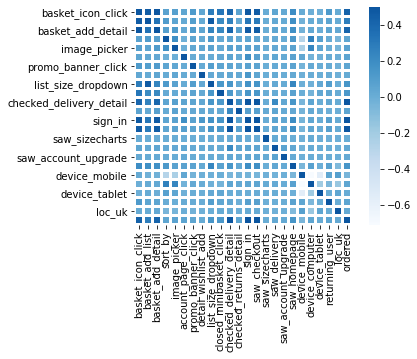

In [10]:
import matplotlib as plt
corr = train_data.corr()
sns.heatmap(corr, vmax=0.5, center=0,
            square=True, linewidths=2, cmap='Blues')

### Machine Learning

In [79]:
import pandas as pd
data = pd.read_csv("training_sample.csv")
train_data = data.sample(frac=0.8,random_state=200)
test_data = data.drop(train_data.index)
test_data = test_data.drop(columns=['ordered'])

In [73]:
# Drop columns with low correlation
predictors = np.delete(data , [0,19,24], 1)
# predictors = train[['checked_delivery_pdp', 'basket_icon_click', 'sign_in', 'saw_checkout']]
targets = data[:,24]

In [75]:
targets.shape, predictors.shape

((233166,), (233166, 22))

In [76]:
import os
import matplotlib.pylab as plt
from sklearn.model_selection  import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
import sklearn.metrics
X_train, X_test, y_train, y_test  =   train_test_split(predictors, targets, test_size=.3)

print( "Predictor - Training : ", X_train.shape, "Predictor - Testing : ", X_test.shape )

Predictor - Training :  (163216, 22) Predictor - Testing :  (69950, 22)


In [80]:
from sklearn.naive_bayes import GaussianNB

classifier=GaussianNB()
y_train = y_train.astype('int')
classifier=classifier.fit(X_train,y_train)

predictions=classifier.predict(X_test)
y_test=y_test.astype('int')

#Analyze accuracy of predictions
sklearn.metrics.confusion_matrix(y_test,predictions)

array([[66211,   770],
       [   46,  2923]])

In [82]:
sklearn.metrics.accuracy_score(y_test, predictions)

0.9883345246604718

In [84]:
from sklearn.metrics import confusion_matrix
import scikitplot as skplt

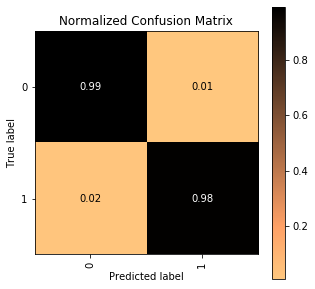

In [88]:
skplt.metrics.plot_confusion_matrix(y_test,predictions,figsize=(5,5),x_tick_rotation=90,cmap='copper_r',normalize = True)

### Deep Learning using Keras Sequential (2-layered)

In [15]:
!pip install keras

  Using cached Keras-2.3.1-py2.py3-none-any.whl (377 kB)
  Using cached Keras_Applications-1.0.8-py3-none-any.whl (50 kB)


In [14]:
!pip install tensorflow

In [24]:
import pandas
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

Using TensorFlow backend.


In [46]:
def create_baseline():
    # create model
    model = Sequential()
    model.add(Dense(6, input_dim=23, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [33]:
import numpy as np
data = np.array(data)

In [43]:
X = np.delete(data, [24,0], 1)
Y = data[:,24]

In [44]:
encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)

In [50]:
# evaluate model with standardized dataset
estimator = KerasClassifier(build_fn=create_baseline, epochs=8, batch_size=50, verbose=0)
kfold = StratifiedKFold(n_splits=10, shuffle=True)
results = cross_val_score(estimator, X, encoded_Y, cv=kfold)
print("Baseline: %.2f%% (%.2f%%)" % (results.mean()*100, results.std()*100))

Baseline: 99.31% (0.04%)


In [1]:
!pip install flask-ngrok

In [2]:
from flask_ngrok import run_with_ngrok
import flask
app = flask.Flask(__name__, template_folder='/')
run_with_ngrok(app)
@app.route('/', methods=['GET', 'POST'])
def main():
    if flask.request.method == 'GET':
        return(flask.render_template('main.html'))
    if flask.request.method == 'POST':
        randnums= np.random.uniform(-1,1,561)
        randnums = randnums.reshape(1,-1)
        fg = model.predict(randnums)
        fgs = str(fg)
        final = ''.join(e for e in fgs if e.isalnum())
        return flask.render_template('main.html', result=final)
if __name__ == '__main__':
    app.run()

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:5000/ (Press CTRL+C to quit)


 * Running on http://90e376d3e1b6.ngrok.io
 * Traffic stats available on http://127.0.0.1:4040


[2020-05-31 05:47:13,337] ERROR in app: Exception on / [GET]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/flask/app.py", line 2446, in wsgi_app
    response = self.full_dispatch_request()
  File "/opt/conda/lib/python3.7/site-packages/flask/app.py", line 1951, in full_dispatch_request
    rv = self.handle_user_exception(e)
  File "/opt/conda/lib/python3.7/site-packages/flask/app.py", line 1820, in handle_user_exception
    reraise(exc_type, exc_value, tb)
  File "/opt/conda/lib/python3.7/site-packages/flask/_compat.py", line 39, in reraise
    raise value
  File "/opt/conda/lib/python3.7/site-packages/flask/app.py", line 1949, in full_dispatch_request
    rv = self.dispatch_request()
  File "/opt/conda/lib/python3.7/site-packages/flask/app.py", line 1935, in dispatch_request
    return self.view_functions[rule.endpoint](**req.view_args)
  File "<ipython-input-2-3d8d320b0bea>", line 8, in main
    return(flask.render_template('main.html'))
  File "/o